In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import time
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
%matplotlib inline

In [2]:
data1 = pd.read_csv('project3_dataset1.txt', sep = '\t', header = None)
data2 = pd.read_csv('project3_dataset2.txt', sep = '\t', header = None)
# column 4 needs to be converted to numerical 1 if present, 0 if absent
data2[4] = data2[4].map({'Present': 1, 'Absent': 0})

In [3]:
data1_X = data1.iloc[:,:30]
data1_y = data1.iloc[:,30]

data2_X = data2.iloc[:,:9]
data2_y = data2.iloc[:,9]

## dataset 1

In [4]:
# call the method and then compute the mean and std
scaler = preprocessing.StandardScaler()
scaler.fit(data1_X)
print(scaler.mean_)
# https://scikit-learn.org/stable/modules/preprocessing.html

[1.41272917e+01 1.92896485e+01 9.19690334e+01 6.54889104e+02
 9.63602812e-02 1.04340984e-01 8.87993158e-02 4.89191459e-02
 1.81161863e-01 6.27976098e-02 4.05172056e-01 1.21685343e+00
 2.86605923e+00 4.03370791e+01 7.04097891e-03 2.54781388e-02
 3.18937163e-02 1.17961371e-02 2.05422988e-02 3.79490387e-03
 1.62691898e+01 2.56772232e+01 1.07261213e+02 8.80583128e+02
 1.32368594e-01 2.54265044e-01 2.72188483e-01 1.14606223e-01
 2.90075571e-01 8.39458172e-02]


In [5]:
# this scales the data to have a mean of zero and a std of 1 for each feature
X1_scaled = scaler.transform(data1_X)
print('Mean: ', sum(X1_scaled)/len(X1_scaled))
print('Standard Deviation: ', np.std(X1_scaled))

Mean:  [-1.62533529e-16  3.70724736e-17  4.20870134e-16  9.20958291e-17
  1.66460284e-16 -8.48764527e-17  3.59017639e-17 -5.01453985e-17
  1.55606830e-16 -1.49333777e-15  6.85840761e-17 -1.19997743e-16
 -8.00960548e-17 -1.65557862e-16 -1.78240551e-16  2.00831589e-16
  1.62728647e-16 -4.48772049e-18  8.74129903e-17 -1.57131191e-17
 -5.34624093e-17 -2.88287262e-17  2.65360864e-17  2.10727745e-16
 -2.32385874e-16  5.26819361e-18  7.80473128e-17 -2.27312799e-16
  2.71604649e-16  1.73411373e-16]
Standard Deviation:  1.0


In [6]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, data1_y, test_size=0.2, random_state=42)

### linear SVM

In [7]:
C_values = [100, 50, 10, 5, 1, 0.5, 0.01, 0.005, 0.001]

# gamma_values

params = [{'C' : C_values}]
scoring = { "accuracy": make_scorer(accuracy_score), "precision": "precision", 
           "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}

scoring_metrics = ['accuracy', 'precision', 'recall','f1','roc_auc']

svm_clf_linear = SVC(kernel = 'linear')

In [8]:
t = time.time()

gs_svm_linear = GridSearchCV(estimator = svm_clf_linear,
                      param_grid=params,
                      scoring=scoring_metrics,
                      cv=10,
                        verbose = 1,
                        refit="accuracy",
                        return_train_score=True)

gs_svm_linear.fit(X1_train, y1_train)

elapsed = time.time() - t
print('The best parameters found are: ', gs_svm_linear.best_params_)
print('The optimal parameters were found in :', elapsed, ' seconds')
print('The best score was :', gs_svm_linear.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
The best parameters found are:  {'C': 1}
The optimal parameters were found in : 1.131300926208496  seconds
The best score was : 0.9757487922705315


In [33]:
test_scores = list(gs_svm_linear.cv_results_['mean_test_accuracy'])
train_scores = list(gs_svm_linear.cv_results_['mean_train_accuracy'])
layer_num = list(gs_svm_linear.cv_results_['param_C'].data)
heatmap_scores = pd.DataFrame()
heatmap_scores['train accuracy'] = train_scores
heatmap_scores['test accuracy'] = test_scores
heatmap_scores['C'] = layer_num
heatmap_scores = heatmap_scores.set_index('C')
diff = [train_score - test_score for train_score, test_score in zip(train_scores, test_scores)]
#heatmap_scores['diff'] = diff


Text(0.5, 1.0, 'Linear SVM bias variance analysis')

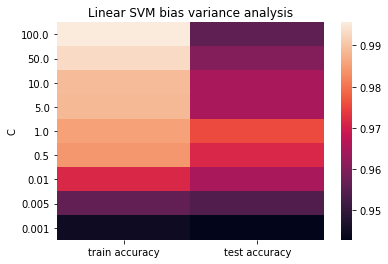

In [36]:
sns.heatmap(heatmap_scores)
plt.title('Linear SVM bias variance analysis')

### polynomial SVM

In [37]:
C_values = [100, 50, 10, 5, 1, 0.5, 0.01, 0.005, 0.001]
degrees = [2,3,4,5,6,7]
gamma_values = [100, 50, 10, 5, 1, 0.5, 0.01, 0.005, 0.001]

params = [{'C' : C_values,
         'degree': degrees,
         'gamma': gamma_values}]

scoring = { "accuracy": make_scorer(accuracy_score), "precision": "precision", 
           "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}

scoring_metrics = ['accuracy', 'precision', 'recall','f1','roc_auc']

svm_clf_poly = SVC(kernel = 'poly')

In [38]:
# there is a bunch of warnings that get thrown here for undefined metrics - for certain parameter sets the model never predicts these 
# sets so the precision is undefined. I acknowledge this, for the best fitting models this isn't a problem - and silence these warnings
from warnings import simplefilter
from sklearn.exceptions import UndefinedMetricWarning
simplefilter("ignore", category=UndefinedMetricWarning)

In [39]:
t = time.time()

gs_svm_poly = GridSearchCV(estimator = svm_clf_poly,
                      param_grid=params,
                      scoring=scoring_metrics,
                      cv=10,
                        verbose = 1,
                        refit="accuracy",
                        return_train_score=True)

gs_svm_poly.fit(X1_train, y1_train)

elapsed = time.time() - t
print('The best parameters found are: ', gs_svm_poly.best_params_)
print('The optimal parameters were found in :', elapsed, ' seconds')
print('The best score was :', gs_svm_poly.best_score_)

Fitting 10 folds for each of 486 candidates, totalling 4860 fits
The best parameters found are:  {'C': 0.01, 'degree': 3, 'gamma': 0.5}
The optimal parameters were found in : 87.58341002464294  seconds


In [40]:
simplefilter("always", category=UndefinedMetricWarning)

In [41]:
# bias variance figure 

### rbf kernel

In [37]:
C_values = [100, 50, 10, 5, 1, 0.5, 0.01, 0.005, 0.001]
gamma_values = [100, 50, 10, 5, 1, 0.5, 0.01, 0.005, 0.001]

params = [{'C' : C_values,
         'gamma': gamma_values}]

scoring = { "accuracy": make_scorer(accuracy_score), "precision": "precision", 
           "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}

scoring_metrics = ['accuracy', 'precision', 'recall','f1','roc_auc']

svm_clf_rbf= SVC(kernel = 'rbf')

In [38]:
# there is a bunch of warnings that get thrown here for undefined metrics - for certain parameter sets the model never predicts these 
# sets so the precision is undefined. I acknowledge this, for the best fitting models this isn't a problem - and silence these warnings
from warnings import simplefilter
from sklearn.exceptions import UndefinedMetricWarning
simplefilter("ignore", category=UndefinedMetricWarning)

In [39]:
t = time.time()

gs_svm_rbf = GridSearchCV(estimator = svm_clf_rbf,
                      param_grid=params,
                      scoring=scoring_metrics,
                      cv=10,
                        verbose = 1,
                        refit="accuracy",
                        return_train_score=True)

gs_svm_rbf.fit(X1_train, y1_train)

elapsed = time.time() - t
print('The best parameters found are: ', gs_svm_rbf.best_params_)
print('The optimal parameters were found in :', elapsed, ' seconds')
print('The best score was :', gs_svm_rbf.best_score_)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
The best parameters found are:  {'C': 5, 'gamma': 0.01}
The optimal parameters were found in : 35.34081315994263  seconds
The best score was : 0.980144927536232


In [40]:
simplefilter("always", category=UndefinedMetricWarning)

In [66]:
test_scores = list(gs_svm_rbf.cv_results_['mean_test_accuracy'])
train_scores = list(gs_svm_rbf.cv_results_['mean_train_accuracy'])
C_num = list(gs_svm_rbf.cv_results_['param_C'].data)
gamma_num = list(gs_svm_rbf.cv_results_['param_gamma'].data)

heatmap_scores = pd.DataFrame()
heatmap_scores['train accuracy'] = train_scores
heatmap_scores['test accuracy'] = test_scores
heatmap_scores['C'] = C_num
heatmap_scores['C'] = 'C: ' + heatmap_scores['C'].astype(str)

heatmap_scores['gamma'] = gamma_num
heatmap_scores['gamma'] = '  gamma: ' + heatmap_scores['gamma'].astype(str)

#heatmap_scores['C'] = heatmap_scores['C'].map(str)
#heatmap_scores['gamma'] = heatmap_scores['gamma'].map(str)


heatmap_scores["label"] = heatmap_scores["C"] + heatmap_scores["gamma"]

#heatmap_scores["label"] = heatmap_scores[['C', 'gamma']].agg('-'.join, axis=1)
heatmap_scores.drop('C', inplace=True, axis=1)
heatmap_scores.drop('gamma', inplace=True, axis=1)
heatmap_scores = heatmap_scores.set_index('label')
diff = [train_score - test_score for train_score, test_score in zip(train_scores, test_scores)]
#heatmap_scores['diff'] = diff
sns.heatmap(heatmap_scores)
plt.title('RBF SVM bias variance analysis')


Text(0.5, 1.0, 'Linear SVM bias variance analysis')

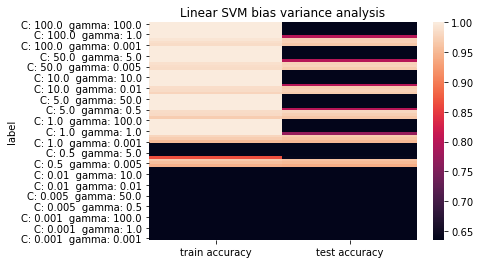

In [67]:
sns.heatmap(heatmap_scores)
plt.title('RBF SVM bias variance analysis')

In [ ]:
test_scores = list(gs_svm_rbf.cv_results_['mean_test_accuracy'])
train_scores = list(gs_svm_rbf.cv_results_['mean_train_accuracy'])
C_num = list(gs_svm_rbf.cv_results_['param_C'].data)
gamma_num = list(gs_svm_rbf.cv_results_['param_gamma'].data)

heatmap_scores = pd.DataFrame()
heatmap_scores['train accuracy'] = train_scores
heatmap_scores['test accuracy'] = test_scores
heatmap_scores['C'] = C_num
heatmap_scores['C'] = 'C: ' + heatmap_scores['C'].astype(str)

heatmap_scores['gamma'] = gamma_num
heatmap_scores['gamma'] = '  gamma: ' + heatmap_scores['gamma'].astype(str)

#heatmap_scores['C'] = heatmap_scores['C'].map(str)
#heatmap_scores['gamma'] = heatmap_scores['gamma'].map(str)


heatmap_scores["label"] = heatmap_scores["C"] + heatmap_scores["gamma"]

#heatmap_scores["label"] = heatmap_scores[['C', 'gamma']].agg('-'.join, axis=1)
heatmap_scores.drop('C', inplace=True, axis=1)
heatmap_scores.drop('gamma', inplace=True, axis=1)
heatmap_scores = heatmap_scores.set_index('label')
diff = [train_score - test_score for train_score, test_score in zip(train_scores, test_scores)]
#heatmap_scores['diff'] = diff


sns.heatmap(heatmap_scores)
plt.title('Linear SVM bias variance analysis')

In [18]:
## best parameter are an rbf kernel, C = 5 and gamma = 0.01
## Retrain with these parameters and test

In [19]:
final_model = SVC(kernel = 'rbf', C = 5, gamma = 0.01)
final_model.fit(X1_train, y1_train)
train_scores = cross_validate(final_model, X1_train, y1_train, cv=10, scoring=scoring_metrics)
predictions1 = final_model.predict(X1_test)

In [20]:
data = [["Mean score of 10 fold CV on training set\n", np.mean(train_scores['test_accuracy']), np.mean(train_scores['test_precision']), np.mean(train_scores['test_recall']),
         np.mean(train_scores['test_f1']), np.mean(train_scores['test_roc_auc'])], 
         ["Test Scores", sklearn.metrics.accuracy_score(y1_test, predictions1), sklearn.metrics.precision_score(y1_test, predictions1), 
        sklearn.metrics.recall_score(y1_test, predictions1), sklearn.metrics.f1_score(y1_test, predictions1),
          sklearn.metrics.roc_auc_score(y1_test, predictions1)]]
print(tabulate(data, headers=["Accuracy", "Precision", "Recall", "F1", "AUC"]))


                                            Accuracy    Precision    Recall        F1       AUC
----------------------------------------  ----------  -----------  --------  --------  --------
Mean score of 10 fold CV on training set    0.980145     0.988194  0.957353  0.971457  0.993645
Test Scores                                 0.973684     0.977778  0.956522  0.967033  0.970908


In [21]:
data = [['Accuracy', np.mean(train_scores['test_accuracy']), sklearn.metrics.accuracy_score(y1_test, predictions1)],
['Precision', np.mean(train_scores['test_precision']),sklearn.metrics.precision_score(y1_test, predictions1)],
['Recall', np.mean(train_scores['test_recall']), sklearn.metrics.recall_score(y1_test, predictions1)],
['F1', np.mean(train_scores['test_f1']), sklearn.metrics.f1_score(y1_test, predictions1)],
['AUC', np.mean(train_scores['test_roc_auc']), sklearn.metrics.roc_auc_score(y1_test, predictions1)]]
print (tabulate(data, headers=["metric", "Mean score of 10 fold cross validation on training set", "Test Scores"]))

metric       Mean score of 10 fold cross validation on training set    Test Scores
---------  --------------------------------------------------------  -------------
Accuracy                                                   0.980145       0.973684
Precision                                                  0.988194       0.977778
Recall                                                     0.957353       0.956522
F1                                                         0.971457       0.967033
AUC                                                        0.993645       0.970908


## dataset2

In [68]:
# call the method and then compute the mean and std
scaler = preprocessing.StandardScaler()
scaler.fit(data2_X)
print(scaler.mean_)
# https://scikit-learn.org/stable/modules/preprocessing.html

[138.32683983   3.63564935   4.74032468  25.4067316    0.41558442
  53.1038961   26.04411255  17.04439394  42.81601732]


In [69]:
# this scales the data to have a mean of zero and a std of 1 for each feature
X2_scaled = scaler.transform(data2_X)
print('Mean: ', sum(X2_scaled)/len(X2_scaled))
print('Standard Deviation: ', np.std(X2_scaled))

Mean:  [-2.04742428e-16 -6.87280920e-17  3.47004772e-16  1.87440251e-16
  1.13425383e-16 -1.10541686e-16 -2.27331381e-16  4.13630169e-17
  1.44184808e-18]
Standard Deviation:  1.0


In [70]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, data2_y, test_size=0.2, random_state=42)

### linear svm

In [71]:
C_values = [100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

# gamma_values

params = [{'C' : C_values}]
scoring = { "accuracy": make_scorer(accuracy_score), "precision": "precision", 
           "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}

scoring_metrics = ['accuracy', 'precision', 'recall','f1','roc_auc']

svm_clf_linear = SVC(kernel = 'linear')

In [72]:
# there is a bunch of warnings that get thrown here for undefined metrics - for certain parameter sets the model never predicts these 
# sets so the precision is undefined. I acknowledge this, for the best fitting models this isn't a problem - and silence these warnings
from warnings import simplefilter
from sklearn.exceptions import UndefinedMetricWarning
simplefilter("ignore", category=UndefinedMetricWarning)

In [73]:
t = time.time()

gs_svm_linear = GridSearchCV(estimator = svm_clf_linear,
                      param_grid=params,
                      scoring=scoring_metrics,
                      cv=10,
                        verbose = 1,
                        refit="accuracy",
                        return_train_score=True)

gs_svm_linear.fit(X2_train, y2_train)

elapsed = time.time() - t
print('The best parameters found are: ', gs_svm_linear.best_params_)
print('The optimal parameters were found in :', elapsed, ' seconds')
print('The best score was :', gs_svm_linear.best_score_)

Fitting 10 folds for each of 11 candidates, totalling 110 fits
The best parameters found are:  {'C': 0.5}
The optimal parameters were found in : 2.6852500438690186  seconds
The best score was : 0.728978978978979


In [74]:
simplefilter("always", category=UndefinedMetricWarning)

Text(0.5, 1.0, 'Linear SVM bias variance analysis')

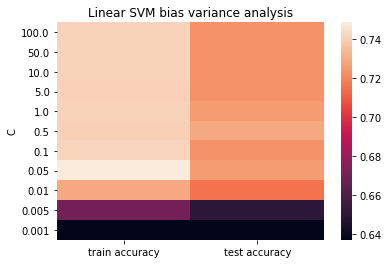

In [76]:
test_scores = list(gs_svm_linear.cv_results_['mean_test_accuracy'])
train_scores = list(gs_svm_linear.cv_results_['mean_train_accuracy'])
layer_num = list(gs_svm_linear.cv_results_['param_C'].data)
heatmap_scores = pd.DataFrame()
heatmap_scores['train accuracy'] = train_scores
heatmap_scores['test accuracy'] = test_scores
heatmap_scores['C'] = layer_num
heatmap_scores = heatmap_scores.set_index('C')
diff = [train_score - test_score for train_score, test_score in zip(train_scores, test_scores)]
#heatmap_scores['diff'] = diff

sns.heatmap(heatmap_scores)
plt.title('Linear SVM bias variance analysis')



### polynomial svm

In [22]:
C_values = [5, 1, 0.5, 0.01, 0.05]
degrees = [2,3,4,5]
gamma_values = [1, 0.5, 0.01, 0.05]

params = [{'C' : C_values,
         'degree': degrees,
         'gamma': gamma_values}]

scoring = { "accuracy": make_scorer(accuracy_score), "precision": "precision", 
           "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}

scoring_metrics = ['accuracy', 'precision', 'recall','f1','roc_auc']

svm_clf_poly = SVC(kernel = 'poly')

In [16]:
# there is a bunch of warnings that get thrown here for undefined metrics - for certain parameter sets the model never predicts these 
# sets so the precision is undefined. I acknowledge this, for the best fitting models this isn't a problem - and silence these warnings
from warnings import simplefilter
from sklearn.exceptions import UndefinedMetricWarning
simplefilter("ignore", category=UndefinedMetricWarning)

In [23]:
# this takes wayyy longer to run, so ill reduce the parameter space
t = time.time()

gs_svm_poly = GridSearchCV(estimator = svm_clf_poly,
                      param_grid=params,
                      scoring=scoring_metrics,
                      cv=10,
                        verbose = 1,
                        refit="accuracy",
                        return_train_score=True)

gs_svm_poly.fit(X2_train, y2_train)

elapsed = time.time() - t
print('The best parameters found are: ', gs_svm_poly.best_params_)
print('The optimal parameters were found in :', elapsed, ' seconds')
print('The best score was :', gs_svm_poly.best_score_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
The best parameters found are:  {'C': 0.01, 'degree': 3, 'gamma': 0.5}
The optimal parameters were found in : 16.110707998275757  seconds
The best score was : 0.7073573573573573


In [24]:
simplefilter("always", category=UndefinedMetricWarning)

In [ ]:
# bias variance figure

### rbf

In [77]:
C_values = [100, 50,20,15,10, 5, 1, 0.5, 0.1, 0.05, 0.01]
gamma_values = [5,1, 0.5, 0.1, 0.01, 0.05]

params = [{'C' : C_values,
         'gamma': gamma_values}]

scoring = { "accuracy": make_scorer(accuracy_score), "precision": "precision", 
           "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}

scoring_metrics = ['accuracy', 'precision', 'recall','f1','roc_auc']

svm_clf_rbf = SVC(kernel = 'rbf')

In [78]:
# there is a bunch of warnings that get thrown here for undefined metrics - for certain parameter sets the model never predicts these 
# sets so the precision is undefined. I acknowledge this, for the best fitting models this isn't a problem - and silence these warnings
from warnings import simplefilter
from sklearn.exceptions import UndefinedMetricWarning
simplefilter("ignore", category=UndefinedMetricWarning)

In [79]:
# this takes wayyy longer to run, so ill reduce the parameter space
t = time.time()

gs_svm_rbf = GridSearchCV(estimator = svm_clf_rbf,
                      param_grid=params,
                      scoring=scoring_metrics,
                      cv=10,
                        verbose = 1,
                        refit="accuracy",
                        return_train_score=True)

gs_svm_rbf.fit(X2_train, y2_train)

elapsed = time.time() - t
print('The best parameters found are: ', gs_svm_rbf.best_params_)
print('The optimal parameters were found in :', elapsed, ' seconds')
print('The best score was :', gs_svm_rbf.best_score_)

Fitting 10 folds for each of 66 candidates, totalling 660 fits
The best parameters found are:  {'C': 20, 'gamma': 0.01}
The optimal parameters were found in : 18.097798824310303  seconds
The best score was : 0.7452702702702703


In [80]:
simplefilter("always", category=UndefinedMetricWarning)

In [81]:
test_scores = list(gs_svm_rbf.cv_results_['mean_test_accuracy'])
train_scores = list(gs_svm_rbf.cv_results_['mean_train_accuracy'])
C_num = list(gs_svm_rbf.cv_results_['param_C'].data)
gamma_num = list(gs_svm_rbf.cv_results_['param_gamma'].data)

heatmap_scores = pd.DataFrame()
heatmap_scores['train accuracy'] = train_scores
heatmap_scores['test accuracy'] = test_scores
heatmap_scores['C'] = C_num
heatmap_scores['C'] = 'C: ' + heatmap_scores['C'].astype(str)

heatmap_scores['gamma'] = gamma_num
heatmap_scores['gamma'] = '  gamma: ' + heatmap_scores['gamma'].astype(str)

#heatmap_scores['C'] = heatmap_scores['C'].map(str)
#heatmap_scores['gamma'] = heatmap_scores['gamma'].map(str)


heatmap_scores["label"] = heatmap_scores["C"] + heatmap_scores["gamma"]

#heatmap_scores["label"] = heatmap_scores[['C', 'gamma']].agg('-'.join, axis=1)
heatmap_scores.drop('C', inplace=True, axis=1)
heatmap_scores.drop('gamma', inplace=True, axis=1)
heatmap_scores = heatmap_scores.set_index('label')
diff = [train_score - test_score for train_score, test_score in zip(train_scores, test_scores)]
#heatmap_scores['diff'] = diff


Text(0.5, 1.0, 'RBF SVM bias variance analysis')

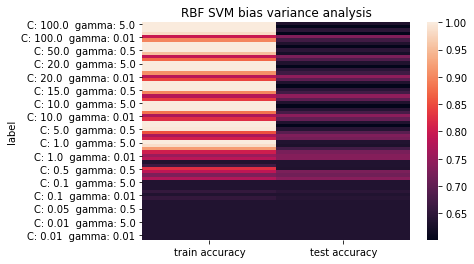

In [82]:
sns.heatmap(heatmap_scores)
plt.title('RBF SVM bias variance analysis')

In [39]:
## based on accuracy, the best parameters are rbf with C = 20 and gamma = 0.01
## I'll retrain on all training data and give the test accuracy now

## final model

In [41]:
final_model = SVC(kernel = 'rbf', C = 20, gamma = 0.01)
final_model.fit(X2_train, y2_train)
train_scores = cross_validate(final_model, X2_train, y2_train, cv=10, scoring=scoring_metrics)
predictions2 = final_model.predict(X2_test)

In [42]:
data = [["Mean score of 10 fold CV on training set\n", np.mean(train_scores['test_accuracy']), np.mean(train_scores['test_precision']), np.mean(train_scores['test_recall']),
         np.mean(train_scores['test_f1']), np.mean(train_scores['test_roc_auc'])], 
         ["Test Scores", sklearn.metrics.accuracy_score(y2_test, predictions2), sklearn.metrics.precision_score(y2_test, predictions2), 
        sklearn.metrics.recall_score(y2_test, predictions2), sklearn.metrics.f1_score(y2_test, predictions2),
          sklearn.metrics.roc_auc_score(y2_test, predictions2)]]
print(tabulate(data, headers=["Accuracy", "Precision", "Recall", "F1", "AUC"]))

                                            Accuracy    Precision    Recall        F1       AUC
----------------------------------------  ----------  -----------  --------  --------  --------
Mean score of 10 fold CV on training set    0.74527      0.692114  0.537912  0.600444  0.760844
Test Scores                                 0.731183     0.518519  0.538462  0.528302  0.672216


In [43]:
data = [['Accuracy', np.mean(train_scores['test_accuracy']), sklearn.metrics.accuracy_score(y2_test, predictions2)],
['Precision', np.mean(train_scores['test_precision']),sklearn.metrics.precision_score(y2_test, predictions2)],
['Recall', np.mean(train_scores['test_recall']), sklearn.metrics.recall_score(y2_test, predictions2)],
['F1', np.mean(train_scores['test_f1']), sklearn.metrics.f1_score(y2_test, predictions2)],
['AUC', np.mean(train_scores['test_roc_auc']), sklearn.metrics.roc_auc_score(y2_test, predictions2)]]
print (tabulate(data, headers=["metric", "Mean score of 10 fold cross validation on training set", "Test Scores"]))

metric       Mean score of 10 fold cross validation on training set    Test Scores
---------  --------------------------------------------------------  -------------
Accuracy                                                   0.74527        0.731183
Precision                                                  0.692114       0.518519
Recall                                                     0.537912       0.538462
F1                                                         0.600444       0.528302
AUC                                                        0.760844       0.672216
